In [3]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
from pymatsolver import PardisoSolver
import numpy as np
# from SimPEG.Problem import GlobalProblem as GlobalProblem

In [4]:
from scipy.constants import mu_0
def genTensorMesh(locs, sigma=1e-3, t=1e-2, dx=np.r_[50., 50., 50.], ncx=5,ncy=5,ncz=4,npad=8):    
    difdist = np.sqrt(2*t/mu_0/sigma)
    hx = [(dx[0],npad,-1.3), (dx[0],ncx), (dx[0],npad,1.3)]
    hy = [(dx[1],npad,-1.3), (dx[1],ncy), (dx[1],npad,1.3)]
#     hz = [(dx[2],npad,-1.3), (dx[2],ncz),(dx[2]*0.5, 4),(dx[2],ncz),(dx[2],npad,1.3)]
    hz = [(dx[2],npad-2,-1.3), (dx[2],ncz), (dx[2],ncz),(dx[2],npad-2,1.3)]    
    mesh = Mesh.TensorMesh([hx, hy, hz], x0="CCC")
    mesh._x0 += locs
    return mesh    

In [5]:
hx = np.ones(10)*50
meshsurvey = Mesh.TensorMesh([hx], "C")
locs = np.c_[meshsurvey.gridCC, np.ones(meshsurvey.nC)*0., np.ones(meshsurvey.nC)]
itx = Utils.closestPoints(meshsurvey, np.r_[0.])[0]

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Step1: set up survey

In [7]:
# mesh = Mesh.TensorMesh.readUBC("./models/mesh_composite.msh")
# sigma = mesh.readModelUBC("./models/sigmaInf_composite_cond.con")

In [8]:
cs, ncx, ncy, ncz, npad = 50., 12, 12, 16, 8
hx = [(cs,npad,-1.3), (cs,ncx), (cs,npad,1.3)]
hy = [(cs,npad,-1.3), (cs,ncy), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]

In [9]:
mesh = Mesh.TensorMesh([hx, hy, hz], "CCC")

In [10]:
sigma = np.ones(mesh.nC)*1e-8
sigma[mesh.gridCC[:,2]<0.] = 1e-3
blk = Utils.ModelBuilder.getIndicesBlock(np.r_[-100., 100., -50.], np.r_[100., -100., -250.], mesh.gridCC)
sigma[blk] = 1e-1

-125.0


(-1200, 1200)

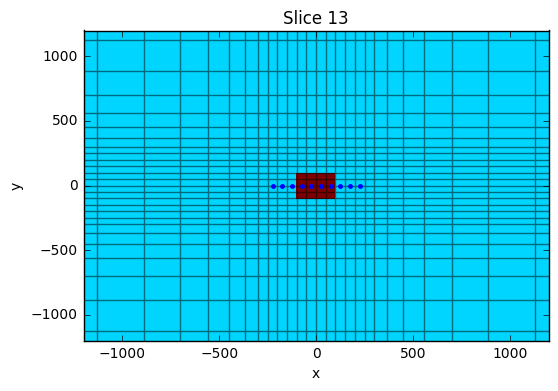

In [11]:
print mesh.vectorCCz[13]
mesh.plotSlice(np.log10(sigma), ind=13, grid=True, clim=(-4, -1))
plt.plot(locs[:,0], locs[:,1], '.')
xlim(-1200, 1200)
ylim(-1200, 1200)

-125.0


(-1200, 0.0)

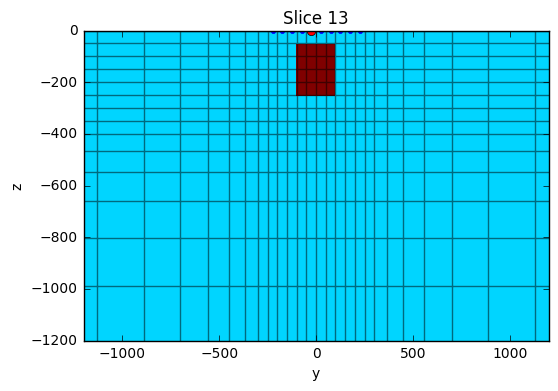

In [12]:
print mesh.vectorCCz[13]
mesh.plotSlice(np.log10(sigma), ind=13,normal='X', grid=True, clim=(-4, -1))
plt.plot(locs[:,0], locs[:,1], '.')
plt.plot(locs[itx,0], locs[itx,1], 'ro')
xlim(-1200, 1200)
ylim(-1200, 0.)

## Generate submeshes and mapping

In [13]:
submeshes = []
submaps = []
ntx = locs.shape[0]
inactind = mesh.gridCC[:,2] > 0.
for itx in range(ntx):
    meshsub = genTensorMesh(locs[itx,:])
    inactindsub = meshsub.gridCC[:,2] > 0.
    M2Mmap = Maps.Mesh2MeshTopo([mesh, meshsub], [~inactind, ~inactindsub])
    actmap = Maps.ActiveCells(meshsub, ~inactindsub, 1e-8)
#     expmap = Maps.ExpMap(meshsub)
#     mapping = expmap*actmap*M2Mmap
    mapping = actmap*M2Mmap
    submaps.append(mapping)
    submeshes.append(meshsub)

/Users/sgkang/Projects/simpeg/SimPEG/Maps.py:1489: FutureWarning: `ActiveCells` is deprecated and will be removed in future versions. Use `InjectActiveCells` instead
  FutureWarning)


In [14]:
def fun(itx=0):
#     itx = 3
    condsub = submaps[itx]*sigma[~inactind]
    print submeshes[itx].vectorCCz[7]
    submeshes[itx].plotSlice(np.log10(condsub), ind=7, grid=True, clim=(-4, -1))
    plt.plot(locs[:,0], locs[:,1], '.')
    plt.plot(locs[itx,0], locs[itx,1], 'ro')
    xlim(-1200, 1200)
    ylim(-1200, 1200)


In [15]:
from ipywidgets import interact

-124.0


<function __main__.fun>

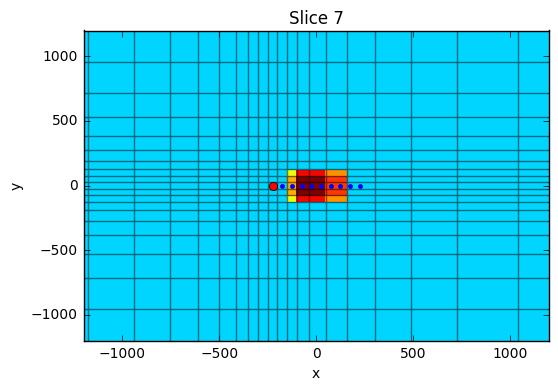

In [16]:
interact(fun, itx=(0, 9, 1))

-124.0


(-500, 50.0)

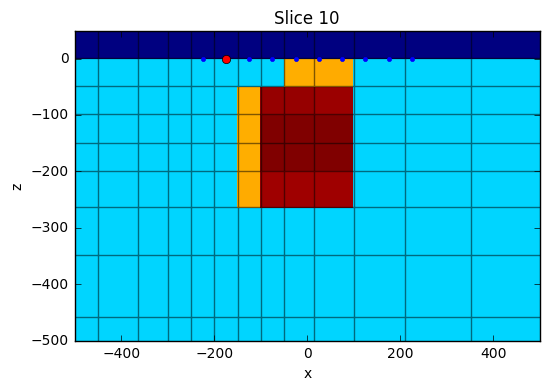

In [17]:
itx = 1
condsub = submaps[itx]*sigma[~inactind]
print submeshes[itx].vectorCCz[7]
submeshes[itx].plotSlice(np.log10(condsub), normal='Y', grid=True, clim=(-4, -1))
plt.plot(locs[:,0], locs[:,1], '.')
plt.plot(locs[itx,0], locs[itx,1], 'ro')
xlim(-500, 500)
ylim(-500, 50.)

-124.0


(-500, 50.0)

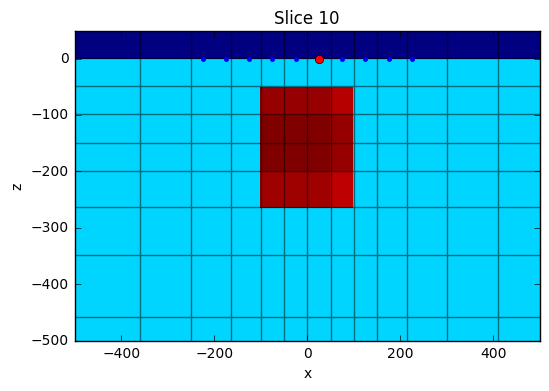

In [18]:
itx = 5
condsub = submaps[itx]*sigma[~inactind]
print submeshes[itx].vectorCCz[7]
submeshes[itx].plotSlice(np.log10(condsub), normal='Y', grid=True, clim=(-4, -1))
plt.plot(locs[:,0], locs[:,1], '.')
plt.plot(locs[itx,0], locs[itx,1], 'ro')
xlim(-500, 500)
ylim(-500, 50.)

-125.0


(-500, 50.0)

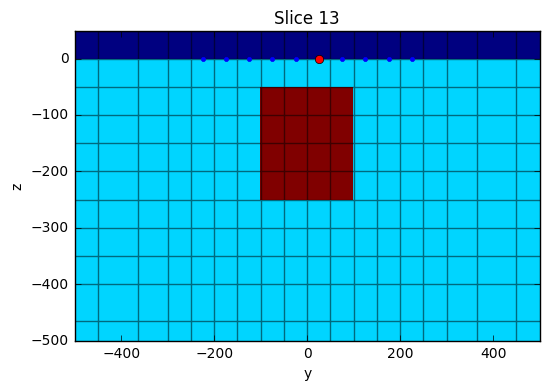

In [19]:
print mesh.vectorCCz[13]
mesh.plotSlice(np.log10(sigma), ind=13,normal='X', grid=True, clim=(-4, -1))
plt.plot(locs[:,0], locs[:,1], '.')
plt.plot(locs[itx,0], locs[itx,1], 'ro')
xlim(-500, 500)
ylim(-500, 50.)

In [58]:
rxLists = []
srcLists = []
times = np.logspace(-4, -3, 11)
for itx in range(ntx):
    rxtmp = EM.TDEM.RxTDEM(locs[itx,:].reshape([1,-1]), times, 'bz')
    rxLists.append(rxtmp)
    srctmp = EM.TDEM.SrcTDEM_CircularLoop_MVP([rxtmp], locs[itx,:].reshape([1,-1]), 13., "STEPOFF")
    srcLists.append(srctmp)

In [59]:
from simpegAIP.TD import ATEM_b
from pymatsolver import MumpsSolver

In [60]:
# prob =ATEM_b.ProblemATEM_b(mesh, Solver=MumpsSolver)
# survey = EM.TDEM.SurveyTDEM(srcLists)
# prob.pair(survey)
# prob.timeSteps = [(5e-5, 10), (1e-4, 10), (5e-4, 10)]
# pred = survey.dpred(sigma)
# pred = pred.reshape((times.size, ntx), order='F')
# np.save('./data/pred', pred)

In [61]:
# plt.semilogy(locs[:,0], pred.T, 'k-')

In [62]:
class IdentityMapXXX(Maps.IdentityMap):
    nCactive = None
    def __init__(self, mesh, **kwargs):
        Maps.IdentityMap.__init__(self, mesh, **kwargs)
    
    @property
    def nP(self):
        """
            :rtype: int
            :return: number of parameters in the model
        """
        if self.nCactive is None:
            raise Exception('Set nCactive')            
        return self.nCactive

    @property
    def shape(self):
        """
            The default shape is (mesh.nC, nP).

            :rtype: (int,int)
            :return: shape of the operator as a tuple
        """
        return (self.nP, self.nP)

In [21]:
# imap = IdentityMapXXX(mesh)
# imap.nCactive = (~inactind).sum()

In [64]:
imap = Maps.IdentityMap(nP=int((~inactind).sum()))

In [74]:
GP = GlobalProblem(ATEM_b.ProblemATEM_b, mesh, mapping=imap, meshes=submeshes)
survey = EM.TDEM.SurveyTDEM(srcLists)
survey.pair(GP) #other way does not work GP.pair(survey)

In [67]:
# m = np.log(sigma[~inactind])
m = sigma[~inactind]
preddecom = []
for itx in range(ntx):
    prbtmp, surveytmp =  GP.getSubProblemandSubSurvey(submaps[itx], itx)
#     prbtmp.verbose = True
    prbtmp.Solver = MumpsSolver
    prbtmp.timeSteps = [(5e-5, 10), (1e-4, 10), (5e-4, 10)]
    predtmp = surveytmp.dpred(m)
    preddecom.append(predtmp)
    print (">> Source %i")%(itx)

>> Step waveform: Non-zero initial condition
>> Source 0
>> Step waveform: Non-zero initial condition
>> Source 1
>> Step waveform: Non-zero initial condition
>> Source 2
>> Step waveform: Non-zero initial condition
>> Source 3
>> Step waveform: Non-zero initial condition
>> Source 4
>> Step waveform: Non-zero initial condition
>> Source 5
>> Step waveform: Non-zero initial condition
>> Source 6
>> Step waveform: Non-zero initial condition
>> Source 7
>> Step waveform: Non-zero initial condition
>> Source 8
>> Step waveform: Non-zero initial condition
>> Source 9


In [68]:
pred = np.load("./data/pred.npy")

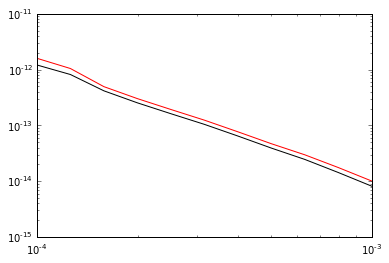

In [69]:
itx = 9
plt.loglog(times, pred[:,itx], 'k')
plt.loglog(times, preddecom[itx], 'r')


In [70]:
pred_test = (np.vstack(preddecom)).flatten()
pred_test = pred_test.reshape((times.size, ntx), order='F')

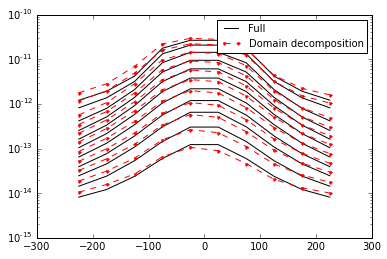

In [71]:
for itime in range(times.size):
    plt.semilogy(locs[:,0], pred[itime,:], 'k-')
    plt.semilogy(locs[:,0], pred_test[itime,:], 'r.--')
    if itime==0:
        legend(("Full", "Domain decomposition"), loc=1, fontsize = 10)

In [29]:
# survey = EM.FDEM.Survey([Src0, Src1])
# GP.pair(survey)

# gp1 = GP.getSubProblem(0)
# gp1.Solver = MumpsSolver

# pu = prb0.fields(m)
# gpu = gp1.fields(m)

# bfz = mesh.r(pu[Src0, 'b'],'F','Fz','M')
# bfz = mesh.r(gpu[Src0, 'b'],'F','Fz','M')
# x = np.linspace(-55,55,12)
# XYZ = Utils.ndgrid(x,np.r_[0],np.r_[0])
# P = mesh.getInterpolationMat(XYZ, 'Fz')

# # an = EM.Analytics.FDEM.hzAnalyticDipoleF(x, Src0.freq, sig)

# # diff = np.log10(np.abs(P*np.imag(pu[Src0, 'b']) - mu_0*np.imag(an)))
# # diff = np.log10(np.abs(P*np.imag(gpu[Src0, 'b']) - mu_0*np.imag(an)))

# import matplotlib.pyplot as plt
# plt.plot(x,np.log10(np.abs(P*np.imag(pu[Src0, 'b']))), 'r-s')
# plt.plot(x,np.log10(np.abs(P*np.imag(gpu[Src0, 'b']))), 'b')
# # plt.plot(x,np.log10(np.abs(mu_0*np.imag(an))), 'r')
# # plt.plot(x,diff,'g')
# plt.show()
